### S'24 795/895 DL Fundamentals Final Project

**Important**: Rename the notebook with the UID of one of the team members as the prefix, such as jdoe001_xxxxxxx.ipynb.

**Important**: Contributer:Ashish Verma

#### Description
The task of the project is to implement CIFAR10 classification using LeNet. The second task is to use transfer learning to adapt the LeNet model trained on CIFAR10 data to STL-10.

#### Background:
LeNet is one of the *old* CNN models. Its structure can be described as: CONV-Pooling-CONV-Pooling-FC-FC. Below is a pictorial description:

![Screenshot 2024-03-20 at 1.48.02 PM.png](attachment:aa307695-8043-4875-9252-50ebd72643fd.png)

Both CIFAR10 and STL-10 are included in Torchvision. More details are at https://pytorch.org/vision/stable/datasets.html
#### Specific Requirements
1. You are required to implement it in PyTorch
2. You are required to use Dropout layers
3. You are required to use GPU.
4. You can use either colab or ODU HPC resources. It will take some time to train the model, hence I **strongly** suggest you start early.
5. You should implement it from scratch (Hint: there aren't too many examples of using LeNet for CIFAR10, so you have to write it yourself)
6. It has been reported that LeNet can achieve testing accuracy of ~65% for CIFAR10. I will accept any results with accuracy > 58% (If it's < 50%, it's acutally worse than a coin toss!)
7. You probably have to do some hyperparameter tuning to get there.
8. After the model is trained, you are required to use transfer learning method to adapt the model to STL-10 dataset. Retrain the model and achieve as good accuracy as possible.

#### Grading
1. You should implement everything in a single jupyter notebook and submit it before the deadline.
2. I recently aquired a desktop server with a beefy GPU. I **will** run your code to verify the output is correct, besides reading your pytorch code.  If your code won't run to completion, points will be deducted depending on where the failure is (the earlier the failure, the more points will be deducted).

## **Importing Pytorch Libraries**

In [1]:
#Importing libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import matplotlib.pyplot as plt

import gc
import warnings
warnings.filterwarnings('ignore')

## **Initializing GPUs**

In [2]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Data Augmentation and Transformations**

In [3]:
# Setting up the Image transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##  **Data from Torchvision**

In [4]:
# Download the train and test dataset
path = '/tmp'

train_ds = datasets.CIFAR10(root=path,
                            train=True,
                            transform=transform,
                            download=True
                           )

test_ds = datasets.CIFAR10(root=path,
                           train=False,
                           transform=transform
                           )

labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()

100%|██████████| 170498071/170498071 [00:04<00:00, 35020137.89it/s]


Extracting /tmp/cifar-10-python.tar.gz to /tmp


## **Image Visualization**

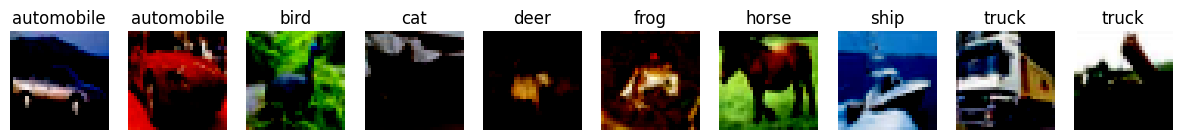

In [5]:
# Visualization of first 10 images
first_10_samples = sorted([train_ds[i] for i in range(10)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,11):
    img = first_10_samples[i-1][0].permute(1,2,0)
    label = labels[first_10_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **Class Config**

In [6]:
# Hyper parameter config
class Config:
    lr=1e-3
    epochs=15
    optim=torch.optim.Adam
    batch_size=64

## **DataLoaders**

In [7]:
# Prepare the data loaders.
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)

## **The LeNET Model**

In [8]:
# LeNet Model class
class LeNet(nn.Module):

    def __init__(self, in_features=3, num_classes=10):
        super(LeNet, self).__init__()

        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                                   out_channels=6,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2,2),
                                         nn.Dropout(0.2),
                                         nn.Conv2d(in_channels=6,
                                                   out_channels=16,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2,2)
                                        )

        self.linear_block = nn.Sequential( nn.Linear(400, 120),
                                           nn.ReLU(),
                                           nn.Linear(120,84),
                                           nn.ReLU(),
                                           nn.Linear(84,10)
                                         )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

# **Model Architecture**

In [9]:
# Show model architecture
model = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## **CIFAR-10 Training**

In [10]:
class Trainer:
    def __init__(self, model, dataloaders, device):
        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim = Config.optim(self.model.parameters(), lr = Config.lr)
        self.device = device

    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)

    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.train_loader:

            self.optim.zero_grad()

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)

        return train_loss, train_acc

    @torch.no_grad()
    def valid_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.valid_loader:

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)

        return valid_loss, valid_acc


    def fit(self):
        print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")
        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []

        for epoch in range(Config.epochs):

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            self.model.eval()

            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            print(f"------EPOCH {epoch+1}/{Config.epochs}------")
            print(f"Training: LOSS: {train_loss:.4f} | ACCURACY: {train_acc:.4f}")
            print(f"Validation: LOSS: {valid_loss:.4f} | ACCURACY: {valid_acc:.4f}\n\n")

            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()


        return (train_losses, train_accs), (valid_losses, valid_accs)

In [11]:
trainer = Trainer(model, (train_dataloader, valid_dataloader), device)

(train_losses, train_accs), (valid_losses, valid_accs) = trainer.fit()

Model is using cuda
------EPOCH 1/15------
Training: LOSS: 1.6776 | ACCURACY: 0.3830
Validation: LOSS: 1.4641 | ACCURACY: 0.4646


------EPOCH 2/15------
Training: LOSS: 1.4036 | ACCURACY: 0.4889
Validation: LOSS: 1.2981 | ACCURACY: 0.5391


------EPOCH 3/15------
Training: LOSS: 1.2805 | ACCURACY: 0.5385
Validation: LOSS: 1.2509 | ACCURACY: 0.5503


------EPOCH 4/15------
Training: LOSS: 1.2022 | ACCURACY: 0.5696
Validation: LOSS: 1.1804 | ACCURACY: 0.5764


------EPOCH 5/15------
Training: LOSS: 1.1435 | ACCURACY: 0.5948
Validation: LOSS: 1.1184 | ACCURACY: 0.5977


------EPOCH 6/15------
Training: LOSS: 1.0961 | ACCURACY: 0.6097
Validation: LOSS: 1.0732 | ACCURACY: 0.6165


------EPOCH 7/15------
Training: LOSS: 1.0561 | ACCURACY: 0.6275
Validation: LOSS: 1.0798 | ACCURACY: 0.6173


------EPOCH 8/15------
Training: LOSS: 1.0214 | ACCURACY: 0.6353
Validation: LOSS: 1.0640 | ACCURACY: 0.6225


------EPOCH 9/15------
Training: LOSS: 0.9931 | ACCURACY: 0.6504
Validation: LOSS: 1.0332 | 

## **CIFAR-10 Plot Losses**

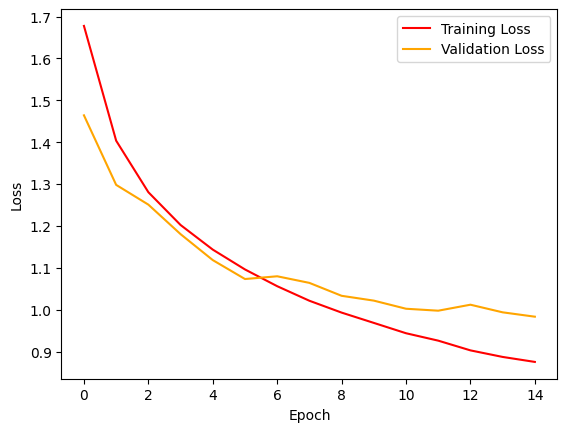

In [12]:
plt.plot(train_losses, color='red', label='Training Loss')
plt.plot(valid_losses, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **CIFAR-10 Plot Accuracy**

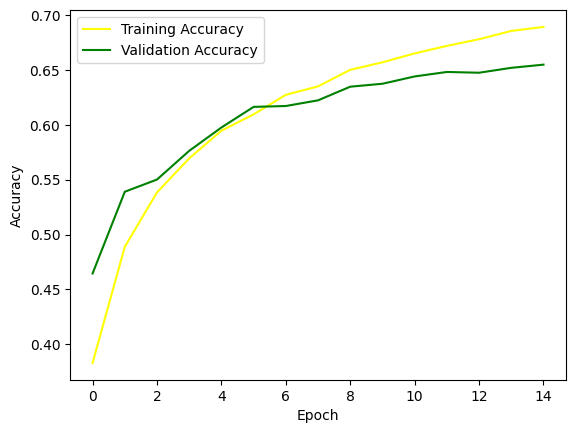

In [13]:
plt.plot(train_accs, color='yellow', label='Training Accuracy')
plt.plot(valid_accs, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Save Model**

In [14]:
## save model for later use
torch.save(model.state_dict(), './lenet_cifar10.pt')

In [15]:
!ls -al *.pt

-rw-r--r-- 1 root root 252108 Apr 13 03:00 lenet_cifar10.pt


# **Load Model**

In [16]:
model.load_state_dict(torch.load('./lenet_cifar10.pt'))
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_block.0.weight 	 torch.Size([6, 3, 5, 5])
conv_block.0.bias 	 torch.Size([6])
conv_block.4.weight 	 torch.Size([16, 6, 5, 5])
conv_block.4.bias 	 torch.Size([16])
linear_block.0.weight 	 torch.Size([120, 400])
linear_block.0.bias 	 torch.Size([120])
linear_block.2.weight 	 torch.Size([84, 120])
linear_block.2.bias 	 torch.Size([84])
linear_block.4.weight 	 torch.Size([10, 84])
linear_block.4.bias 	 torch.Size([10])


# **Data Transformation on STL-10**

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# **Transfer Learning on STL-10**

In [18]:
train_ds_stl = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_ds_stl = datasets.STL10(root='./data', split='test', download=True, transform=transform)


100%|██████████| 2640397119/2640397119 [00:49<00:00, 53332126.12it/s] 


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


# **STL-10 Image Visualization**

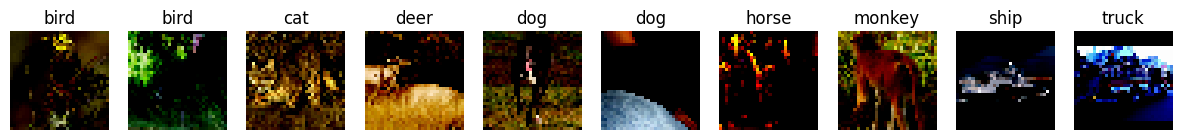

In [19]:
first_10_samples = sorted([train_ds_stl[i] for i in range(10)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,11):
    img = first_10_samples[i-1][0].permute(1,2,0)
    label = train_ds_stl.classes[first_10_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **STL-10 DataLoader**

In [20]:
train_dataloader_stl = torch.utils.data.DataLoader(train_ds_stl, batch_size=64, shuffle=True, num_workers=2)
valid_dataloader_stl = torch.utils.data.DataLoader(test_ds_stl, batch_size=64, shuffle=True, num_workers=2)

# **Create object for STL-10**

In [21]:
model_stl = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# **Load CIFAR-10 for STL-10**

In [22]:
# Load the weights from the trained CIFAR-10 model to the STL-10 model
model_stl.load_state_dict(model.state_dict())

<All keys matched successfully>

# **Train the STL-10 model**

In [23]:
class Trainer_STL:
    def __init__(self, model, dataloaders, device):

        self.config = {
            'lr':1e-4,
            'epochs': 150
        }

        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        #self.optim = torch.optim.Adam(self.model.parameters(), lr = self.config['lr'])
        self.optim = torch.optim.SGD(self.model.parameters(), lr = self.config['lr'],momentum=0.9)
        self.device = device

    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)

    def train_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.train_loader:

            self.optim.zero_grad()

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            loss.backward()
            self.optim.step()

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)

        return train_loss, train_acc

    @torch.no_grad()
    def valid_one_epoch(self):

        running_loss = 0
        running_acc = 0

        for x,y in self.valid_loader:

            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)

            output = self.model(x)

            loss = self.loss_fn(output, y)

            running_loss += loss.item()
            running_acc += self.accuracy(output,y)

            del x,y,output

        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)

        return valid_loss, valid_acc


    def fit(self):

        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []

        for epoch in range(self.config['epochs']):

            print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")

            self.model.train()

            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            self.model.eval()

            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            print(f"------EPOCH {epoch+1}/{self.config['epochs']}------")
            print(f"Training: LOSS: {train_loss:.4f} | ACCURACY: {train_acc:.4f}")
            print(f"Validation: LOSS: {valid_loss:.4f} | ACCURACY: {valid_acc:.4f}\n\n")

            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()


        return (train_losses, train_accs), (valid_losses, valid_accs)

In [24]:
trainer_stl = Trainer_STL(model_stl, (train_dataloader_stl, valid_dataloader_stl), device)
(train_losses_stl, train_accs_stl), (valid_losses_stl, valid_accs_stl) = trainer_stl.fit()

Model is using cuda
------EPOCH 1/150------
Training: LOSS: 3.1117 | ACCURACY: 0.2902
Validation: LOSS: 2.6874 | ACCURACY: 0.2988


Model is using cuda
------EPOCH 2/150------
Training: LOSS: 2.5313 | ACCURACY: 0.2994
Validation: LOSS: 2.3774 | ACCURACY: 0.3091


Model is using cuda
------EPOCH 3/150------
Training: LOSS: 2.3187 | ACCURACY: 0.3002
Validation: LOSS: 2.2037 | ACCURACY: 0.3205


Model is using cuda
------EPOCH 4/150------
Training: LOSS: 2.1662 | ACCURACY: 0.3139
Validation: LOSS: 2.0860 | ACCURACY: 0.3240


Model is using cuda
------EPOCH 5/150------
Training: LOSS: 2.0576 | ACCURACY: 0.3222
Validation: LOSS: 1.9976 | ACCURACY: 0.3327


Model is using cuda
------EPOCH 6/150------
Training: LOSS: 1.9715 | ACCURACY: 0.3271
Validation: LOSS: 1.9267 | ACCURACY: 0.3396


Model is using cuda
------EPOCH 7/150------
Training: LOSS: 1.9114 | ACCURACY: 0.3378
Validation: LOSS: 1.8707 | ACCURACY: 0.3508


Model is using cuda
------EPOCH 8/150------
Training: LOSS: 1.8737 | ACCURAC

# **Plot STL Losses**

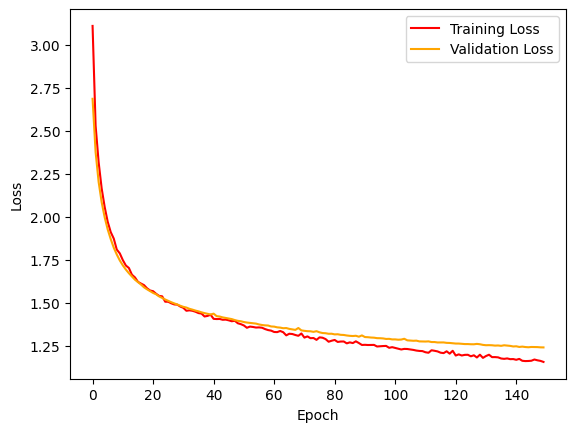

In [25]:
plt.plot(train_losses_stl, color='red', label='Training Loss')
plt.plot(valid_losses_stl, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Plot STL Accuracies**

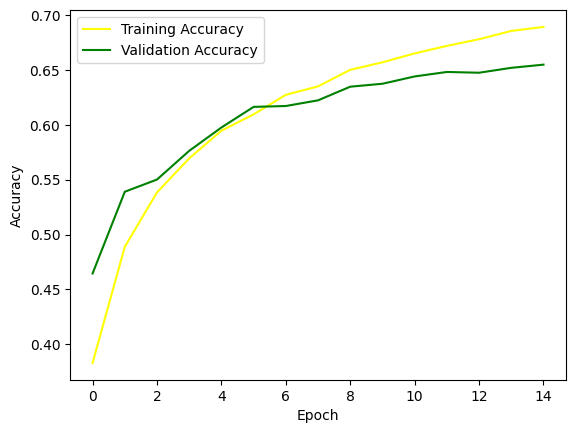

In [26]:
plt.plot(train_accs, color='yellow', label='Training Accuracy')
plt.plot(valid_accs, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
## save model for later use
torch.save(model_stl.state_dict(), './lenet_tranfer_stl10.pt')

# **Inception3 Transfer Learning on STL-10**

In [28]:
# Define transformations for the train and test sets
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # resizing to fit Inception v3 input dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [29]:
batch_size = 64
num_classes = 10
max_epochs=20

# **STl-10 Data Loaders**

In [30]:
# Loading STL-10 dataset
train_dataset = datasets.STL10(root='data/', split='train', transform=transform, download=True)
test_dataset = datasets.STL10(root='data/', split='test', transform=transform, download=True)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# **Download the Pretrained Model**

In [31]:
model_inc = models.inception_v3(pretrained=True)

# Freeze the parameters so we don't backprop through them (optional)
for param in model_inc.parameters():
    param.requires_grad = False

# Replace the classifier
num_ftrs = model_inc.fc.in_features
model_inc.fc = nn.Linear(num_ftrs, 10)  # We have 10 classes in STL-10
model_inc = model_inc.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 84.4MB/s] 


# **Train the InceptionV3  Model**

In [32]:
def train_and_validate_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    # Track performance metrics
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set model to training mode
        train_loss, train_correct, train_total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # combining main and auxiliary losses

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation Phase
        model.eval()  # Set model to evaluate mode
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Only forward pass
                outputs = model(images)

                # In evaluation, we typically use only the main output for validation
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs, labels)

                # Track loss and accuracy
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average losses and accuracy
        epoch_train_loss = train_loss / train_total
        epoch_val_loss = val_loss / val_total
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        # Append epoch statistics to history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return model, history


In [33]:
# Cost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_inc.fc.parameters(), lr=0.001)

model, history = train_and_validate_model(model_inc, criterion, optimizer, train_loader, test_loader, num_epochs=5)

Epoch 1/5:
Train Loss: 4.4828, Train Acc: 84.08%
Val Loss: 0.2633, Val Acc: 95.03%
Epoch 2/5:
Train Loss: 3.9938, Train Acc: 93.76%
Val Loss: 0.1996, Val Acc: 94.99%
Epoch 3/5:
Train Loss: 3.9465, Train Acc: 94.12%
Val Loss: 0.1616, Val Acc: 95.58%
Epoch 4/5:
Train Loss: 3.9153, Train Acc: 94.92%
Val Loss: 0.1436, Val Acc: 95.92%
Epoch 5/5:
Train Loss: 3.9039, Train Acc: 94.84%
Val Loss: 0.1563, Val Acc: 95.36%


# **Plot Loss and Accuracy**

In [34]:
def plot_history(history):
    # Plotting the training and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

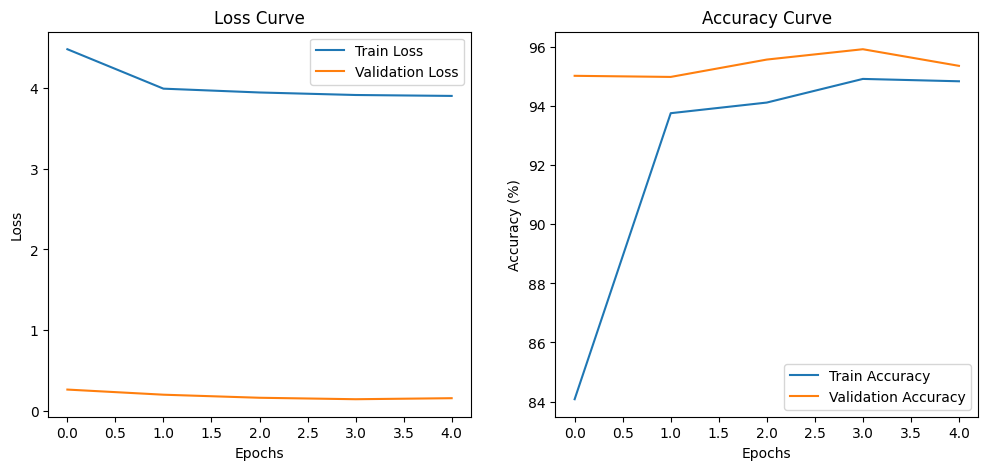

In [35]:
plot_history(history)

In [36]:
## save model for later use
torch.save(model_inc.state_dict(), './incpetionv3_tranfer_stl10.pt')